Problematique : comment prédire l’évolution des maladies (pathologie niveau 1) en fonction des régions ?

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



df = pd.read_csv("effectifs.csv", sep=";")

Étape 1 : Nettoyage des données (Supervisé)
Explication :

On commence par nettoyer les données afin de garantir la qualité du modèle supervisé.
On supprime la région 99, qui correspond à la France entière. Cette valeur pourrait introduire un biais car elle agrège toutes les régions et fausserait l’apprentissage du modèle régional.

In [20]:
df = df.dropna(subset=["Ntop"])

df.drop(df[df["region"] == 99].index, inplace=True)

print("Shape après nettoyage :", df.shape)
print("Valeurs manquantes sur Ntop :", df["Ntop"].isnull().sum())
print("Régions présentes :", sorted(df["region"].unique()))

Shape après nettoyage : (3792196, 16)
Valeurs manquantes sur Ntop : 0
Régions présentes : [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(11), np.int64(24), np.int64(27), np.int64(28), np.int64(32), np.int64(44), np.int64(52), np.int64(53), np.int64(75), np.int64(76), np.int64(84), np.int64(93), np.int64(94)]


Étape 2 : Agrégation des données et calcul de la prévalence
Explication :

Les données sont regroupées par année, région et type de pathologie pour obtenir un niveau d’analyse cohérent pour la modélisation.
On calcule ensuite la prévalence, qui correspond au rapport entre le nombre de cas (Ntop) et la population (Npop).
Cela permet de comparer les régions entre elles indépendamment de leur taille de population.

Enfin, on vérifie la dimension du nouveau jeu de données et l’absence de valeurs manquantes sur la variable calculée.

In [21]:
df_model = (
    df.groupby(["annee", "region", "patho_niv1"])
    .agg({"Ntop": "sum", "Npop": "sum"})
    .reset_index()
)

df_model["prevalence"] = df_model["Ntop"] / df_model["Npop"]

print("Shape df_model :", df_model.shape)
print("NaN dans prevalence :", df_model["prevalence"].isnull().sum())
df_model.head()

Shape df_model : (2826, 6)
NaN dans prevalence : 0


,annee,region,patho_niv1,Ntop,Npop,prevalence
0,2015,1,Affections de longue durée (dont 31 et 32) pou...,110620.0,3008400,0.036770
1,2015,1,Cancers,355180.0,30751080,0.011550
2,2015,1,Diabète,300900.0,2897560,0.103846
3,2015,1,Hospitalisations hors pathologies repérées (av...,388280.0,3008400,0.129065
4,2015,1,Insuffisance rénale chronique terminale,14900.0,7969480,0.001870


Étape 3 : Transformation logarithmique de la variable cible
Explication :

On observe que la distribution initiale de Ntop est fortement asymétrique à droite (skewness élevé).
Après transformation logarithmique, la distribution devient plus équilibrée et plus proche d’une forme normale.
La skewness passe d’une valeur élevée (environ 4.43) à une valeur proche de 0 (environ -0.47), ce qui indique une amélioration significative.
On applique une transformation logarithmique sur la variable Ntop afin de réduire son asymétrie.

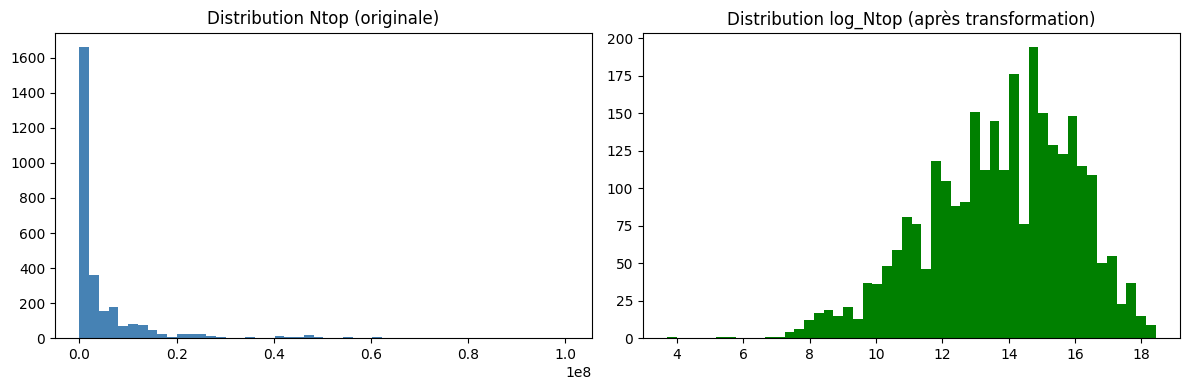

Skewness avant : 4.43
Skewness après : -0.47


In [22]:
df_model["log_Ntop"] = np.log1p(df_model["Ntop"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_model["Ntop"], bins=50, color='steelblue')
axes[0].set_title("Distribution Ntop (originale)")

axes[1].hist(df_model["log_Ntop"], bins=50, color='green')
axes[1].set_title("Distribution log_Ntop (après transformation)")

plt.tight_layout()
plt.show()

print(f"Skewness avant : {df_model['Ntop'].skew():.2f}")
print(f"Skewness après : {df_model['log_Ntop'].skew():.2f}")

Étape 4 : Définition des variables et séparation train/test
Explication :

On définit les variables explicatives (features) et la variable cible (target).
Les variables explicatives sont :
- l’année,
- le type de pathologie,
- la région.

La variable cible correspond à log_Ntop, c’est-à-dire le nombre de cas transformé logarithmiquement.
On sépare ensuite les données en deux ensembles :
- un ensemble d’entraînement (80 %)
- un ensemble de test (20 %)

La fonction train_test_split() permet d’évaluer la performance du modèle sur des données non vues pendant l’apprentissageet le paramètre random_state=42 garantit la reproductibilité des résultats.

In [23]:
features = ["annee", "patho_niv1", "region"]
target = "log_Ntop"

X = df_model[features]
y = df_model[target]

X_pathologies_train, X_pathologies_test, y_pathologies_train, y_pathologies_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_pathologies_train :", X_pathologies_train.shape)
print("X_pathologies_test :", X_pathologies_test.shape)

X_pathologies_train : (2260, 3)
X_pathologies_test : (566, 3)


Étape 5 : Création de la pipeline de preprocessing et du modèle
Explication :

On construit une pipeline complète afin d’automatiser les étapes de préparation des données et l’entraînement du modèle.

In [24]:
numeric_features = ["annee"]
categorical_features = ["region", "patho_niv1"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

print(rf_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['annee']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['region', 'patho_niv1'])])),
               

Étape 6 : Entraînement et évaluation du modèle de Régression Linéaire
Explication :

On crée une pipeline contenant le preprocessing défini précédemment ainsi qu’un modèle de Régression Linéaire.
Le modèle est entraîné sur les données d’entraînement (X_train, y_train) à l’aide de la méthode fit().
On réalise ensuite des prédictions sur l’ensemble de test afin d’évaluer la performance du modèle.

Le R² obtenu est relativement faible, ce qui indique que la relation entre les variables explicatives et la variable cible n’est pas strictement linéaire.
La régression linéaire est donc potentiellement limité face à la complexité des données.

In [25]:
lin_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lin_pipeline.fit(X_pathologies_train, y_pathologies_train)

y_pathologies_pred_lin = lin_pipeline.predict(X_pathologies_test)

rmse_lin = np.sqrt(mean_squared_error(y_pathologies_test, y_pathologies_pred_lin))
r2_lin = r2_score(y_pathologies_test, y_pathologies_pred_lin)

print("Linear Regression")
print("RMSE:", rmse_lin)
print("R2:", r2_lin)

joblib.dump(lin_pipeline, "../model/linear.pkl")


Linear Regression
RMSE: 1.9724720758050072
R2: 0.15629798088844227


['../model/linear.pkl']

Étape 7 : Entraînement et évaluation du modèle Random Forest
Explication :

On entraîne un modèle Random Forest Regressor, intégré dans la pipeline avec le preprocessing.
Après l’entraînement sur les données d’apprentissage, on réalise des prédictions sur l’ensemble de test.

Le modèle Random Forest obtient un R² très élevé (proche de 1), ce qui indique qu’il explique une grande partie de la variance des données.
Le RMSE est plus faible que celui de la régression linéaire, ce qui montre une amélioration des performances.
Donc la relation entre les variables explicatives et la cible est probablement non linéaire, ce qui rend la Random Forest plus adaptée que la régression linéaire pour ce problème.

In [26]:
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

rf_pipeline.fit(X_pathologies_train, y_pathologies_train)

y_pathologies_pred_rf = rf_pipeline.predict(X_pathologies_test)

rmse_rf = np.sqrt(mean_squared_error(y_pathologies_test, y_pathologies_pred_rf))
r2_rf = r2_score(y_pathologies_test, y_pathologies_pred_rf)

print("Random Forest")
print("RMSE:", rmse_rf)
print("R2:", r2_rf)

joblib.dump(rf_pipeline, "../model/random_forest.pkl")

Random Forest
RMSE: 0.28567187006398037
R2: 0.9823028913703654


['../model/random_forest.pkl']

Étape 8 : Entraînement et évaluation du modèle Gradient Boosting
Explication :

On entraîne un modèle Gradient Boosting Regressor, intégré dans la pipeline avec le même preprocessing.
Après l’entraînement sur les données d’apprentissage, on effectue des prédictions sur l’ensemble de test.

Le modèle Gradient Boosting obtient un R² très élevé, proche de celui de la Random Forest, ce qui montre une bonne capacité d’explication des données.
Le RMSE reste faible, ce qui confirme la qualité des prédictions.

Cependant :
- Le modèle est plus sensible aux hyperparamètres.
- Il peut être plus long à entraîner.
- Il existe un risque de surapprentissage (overfitting) si les paramètres ne sont pas bien ajustés.

In [27]:
gb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gb_pipeline.fit(X_pathologies_train, y_pathologies_train)

y_pathologies_pred_gb = gb_pipeline.predict(X_pathologies_test)

rmse_gb = np.sqrt(mean_squared_error(y_pathologies_test, y_pathologies_pred_gb))
r2_gb = r2_score(y_pathologies_test, y_pathologies_pred_gb)

print("Gradient Boosting")
print("RMSE:", rmse_gb)
print("R2:", r2_gb)

joblib.dump(gb_pipeline, "../model/gradient_boosting.pkl")

Gradient Boosting
RMSE: 0.35914581052270395
R2: 0.9720289370546081


['../model/gradient_boosting.pkl']

Conclusion 

Trois modèles de régression ont été comparés afin de prédire l’évolution du nombre de cas (log_Ntop) en fonction de l’année, de la région et du type de pathologie :
- Régression Linéaire
- Random Forest
- Gradient Boosting

La régression linéaire obtient un R² faible, ce qui montre qu’un modèle purement linéaire ne suffit pas à capturer la complexité des données.
La Random Forest obtient un R² très élevé et un RMSE très faible.
Le Gradient Boosting obtient également de très bonnes performances, légèrement inférieures à la Random Forest dans notre cas.

Le Random Forest est donc le meilleur modèle pour ce problème.

Cependant il exite quand meme des limites:

- Risque de surapprentissage avec les modèles complexes
- Les données sont regroupées ce qui peut cacher certains détails ou différences locales
- Les paramètres des modèles n’ont pas été optimisés en profondeur

Conclusion Business

Trois modèles ont été comparés pour prédire l’évolution des pathologies selon l’année et la région.

Les résultats montrent que la Régression Linéaire sous-estime fortement les volumes de cas, ce qui pourrait conduire à une mauvaise anticipation des besoins en santé publique.

En revanche, les modèles Random Forest et Gradient Boosting produisent des estimations cohérentes et fiables. Leur capacité à modéliser des relations complexes permet d’obtenir des prévisions plus réalistes.

Le modèle Random Forest est retenu car il offre la meilleure stabilité et la meilleure précision.